In [4]:
## Load files
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_selection import SelectorMixin

In [8]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_selection import SelectorMixin
from sklearn.utils.validation import check_X_y, check_array
import warnings

warnings.filterwarnings('ignore')

# ---------------------------------------------------------
# 1. Custom Transformer: Outlier Handler
# ---------------------------------------------------------
class OutliersToMedianTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names=None):
        self.feature_names = feature_names
        self.bounds_ = {}

    def fit(self, X, y=None):
        # Handle numpy array vs dataframe
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names)
            
        # Calculate bounds on training data only
        if self.feature_names:
             for col in self.feature_names:
                if col in X.columns:
                    Q1 = X[col].quantile(0.25)
                    Q3 = X[col].quantile(0.75)
                    IQR = Q3 - Q1
                    self.bounds_[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names)
            
        X_copy = X.copy()
        for col, (lower, upper) in self.bounds_.items():
            if col in X_copy.columns:
                mask = (X_copy[col] < lower) | (X_copy[col] > upper)
                # Replace with NaN so Imputer can handle it later
                X_copy.loc[mask, col] = np.nan
        return X_copy

# ---------------------------------------------------------
# 2. Custom Transformer: Advanced Feature Selector (Corrected)
# ---------------------------------------------------------
class AdvancedFeatureSelector(BaseEstimator, SelectorMixin):
    def __init__(self, variance_percentile=0.10, corr_threshold=0.1, check_stability=True):
        self.variance_percentile = variance_percentile
        self.corr_threshold = corr_threshold
        self.check_stability = check_stability
        self.selected_indices_ = []
        self.n_features_in_ = 0 # Initialize

    def fit(self, X, y=None):
        
        # Validate X and y (Standard Scikit-Learn practice)
        # This checks shape, NaN, etc. and ensures X is array-like
        X, y = check_X_y(X, y, accept_sparse=True)
        
        # Set n_features_in_ (CRITICAL FIX)
        self.n_features_in_ = X.shape[1]

        # Convert to DataFrame for easier logic calculation
        # Column names don't matter here, just indices
        df = pd.DataFrame(X)

        # 1. Variance Logic
        variances = df.var()
        threshold = variances.quantile(self.variance_percentile)
        high_variance_mask = variances > threshold

        # 2. Correlation Logic (Signal to Noise proxy)
        if y is not None:
            y_series = pd.Series(y).reset_index(drop=True)
            df_reset = df.reset_index(drop=True)
            
            correlations = df_reset.corrwith(y_series).abs()
            correlations = correlations.fillna(0)
            high_corr_mask = correlations > self.corr_threshold
        else:
            high_corr_mask = pd.Series([False] * len(df.columns))

        # 3. Stability Logic (K-Fold Variance)
        stable_mask = pd.Series([True] * len(df.columns)) # Default True
        if self.check_stability:
            kf = KFold(n_splits=3, shuffle=True, random_state=42)
            stability_scores = []
            
            for train_idx, _ in kf.split(df):
                split_var = df.iloc[train_idx].var()
                stability_scores.append(split_var)
            
            stability_df = pd.DataFrame(stability_scores)
            stability_std = stability_df.std()
            
            # Simple stability check: std of variance shouldn't be huge relative to mean
            # Avoiding division by zero
            mean_std = stability_std.mean()
            if mean_std > 0:
                 stable_mask = stability_std < (mean_std * 2)
            else:
                 stable_mask = pd.Series([True] * len(df.columns))

        # FINAL LOGIC
        final_mask = (high_variance_mask | high_corr_mask) & stable_mask

        
        # Save indices
        self.selected_indices_ = np.where(final_mask)[0]
        
        # Fallback if everything is dropped
        if len(self.selected_indices_) == 0:
            self.selected_indices_ = np.arange(X.shape[1])
            
        return self

    def _get_support_mask(self):
        # SelectorMixin uses this mask to filter X
        mask = np.zeros(self.n_features_in_, dtype=bool)
        mask[self.selected_indices_] = True
        return mask

# ---------------------------------------------------------
# 3. Data Preparation
# ---------------------------------------------------------
df = pd.read_csv("diabetes.csv") 
target_col = "Outcome"

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

skewness = X_train[numerical_cols].apply(lambda x: x.skew()).abs()
skewed_cols = skewness[skewness >= 0.5].index.tolist()
normal_cols = list(set(numerical_cols) - set(skewed_cols))

# ---------------------------------------------------------
# 4. Pipeline Construction
# ---------------------------------------------------------

# A. Numerical Preprocessing
skew_subpipe = Pipeline([
    ('outliers', OutliersToMedianTransformer(feature_names=skewed_cols)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

normal_subpipe = Pipeline([
    ('outliers', OutliersToMedianTransformer(feature_names=normal_cols)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# B. Categorical Preprocessing
cat_subpipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

# C. Column Transformer
preprocessor = ColumnTransformer([
    ('skew', skew_subpipe, skewed_cols),
    ('norm', normal_subpipe, normal_cols),
    ('cat', cat_subpipe, categorical_cols)
], remainder='drop')

# D. Final Pipeline
# Swapped Ridge for LogisticRegression assuming Classification problem
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', AdvancedFeatureSelector(variance_percentile=0.10, corr_threshold=0.05)), 
    ('model', LogisticRegression())
])

# ---------------------------------------------------------
# 5. Execution
# ---------------------------------------------------------

print("Training Pipeline...")
final_pipeline.fit(X_train, y_train)
score = final_pipeline.score(X_test, y_test)
print(f"Test Score (Accuracy): {score:.4f}")

# Optional: Inspect selected features count
selector = final_pipeline.named_steps['feature_selector']
print(f"Features selected: {len(selector.selected_indices_)} out of {selector.n_features_in_}")

# Grid Search
param_grid = {
    'feature_selector__variance_percentile': [0.10, 0.25],
    'model__C': [0.1, 1.0, 10.0] # C is for LogisticRegression
}

print("\nRunning Grid Search...")
grid = GridSearchCV(final_pipeline, param_grid, cv=3)
grid.fit(X_train, y_train)

print(f"Best Params: {grid.best_params_}")
print(f"Best Score: {grid.best_score_*100:.4f}")

Training Pipeline...
Test Score (Accuracy): 0.7403
Features selected: 8 out of 8

Running Grid Search...
Best Params: {'feature_selector__variance_percentile': 0.25, 'model__C': 10.0}
Best Score: 78.3381


Running Grid Search... (Training multiple models)


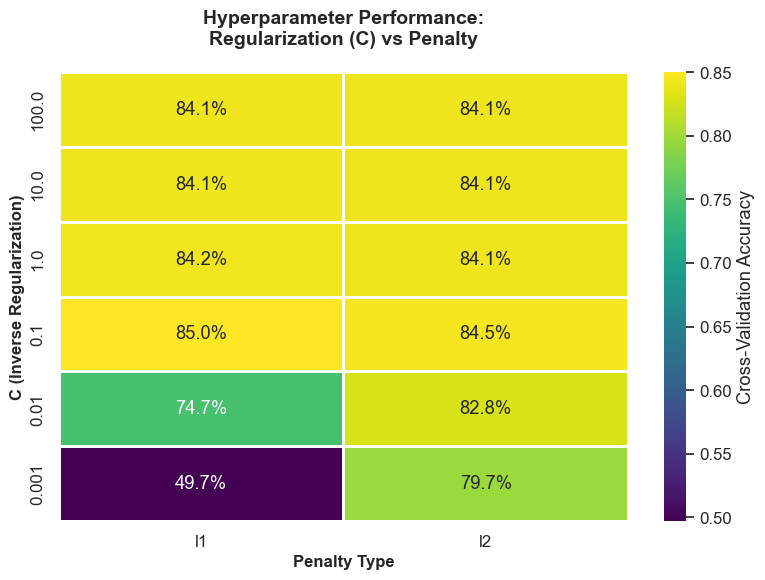

Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l1'}
Best Accuracy: 85.00%


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# ==========================================
# 2. RUN GRID SEARCH (The Math)
# ==========================================
# We use a Pipeline to ensure scaling happens correctly during cross-validation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42)) 
    # 'liblinear' solver supports both L1 and L2 penalties
])

# Define the hyperparameters we want to test
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}

print("Running Grid Search... (Training multiple models)")
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    return_train_score=False
)
grid_search.fit(X, y)

# ==========================================
# 3. PREPARE DATA FOR PLOTTING
# ==========================================
# Convert results into a Pandas DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Pivot the data so it fits a Heatmap (Matrix format)
# Index = C, Columns = Penalty, Values = Accuracy Score
heatmap_data = results_df.pivot(
    index='param_classifier__C', 
    columns='param_classifier__penalty', 
    values='mean_test_score'
)

# ==========================================
# 4. PROFESSIONAL HEATMAP
# ==========================================
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.1) # Slightly larger font for readability

# Draw Heatmap
ax = sns.heatmap(
    heatmap_data,
    annot=True,            # Show the numbers in the boxes
    fmt=".1%",             # Format as percentage (e.g., 95.0%)
    cmap='viridis',        # Professional color gradient (Blue to Yellow)
    cbar_kws={'label': 'Cross-Validation Accuracy'},
    linewidths=1,          # White lines between boxes
    linecolor='white'
)

# Highlights the best score visually
plt.title('Hyperparameter Performance:\nRegularization (C) vs Penalty', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Penalty Type', fontsize=12, fontweight='bold')
plt.ylabel('C (Inverse Regularization)', fontsize=12, fontweight='bold')

# Invert Y axis so small C is at bottom (optional, depends on preference)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.2%}")

Starting Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Params: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'selector__corr_threshold': 0.1, 'selector__variance_percentile': 0.1}
Best CV Score (F1): 0.6528

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.59      0.48      0.53        54

    accuracy                           0.70       154
   macro avg       0.67      0.65      0.66       154
weighted avg       0.69      0.70      0.69       154



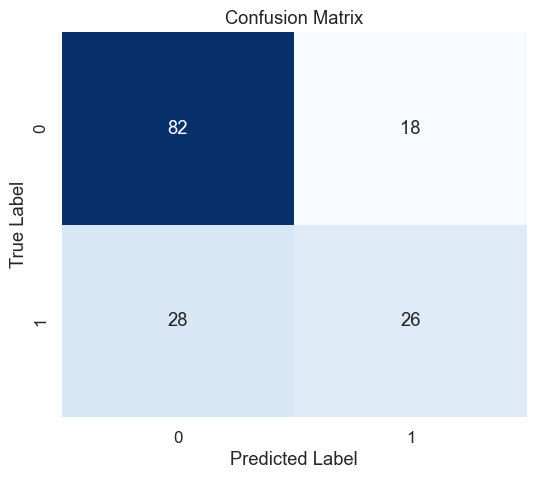

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib  # For saving the model

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_selection import SelectorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# ==========================================
# 1. CUSTOM TRANSFORMERS (Robust & Reusable)
# ==========================================

class OutliersToMedianTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names=None):
        self.feature_names = feature_names
        self.bounds_ = {}

    def fit(self, X, y=None):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names)
        
        if self.feature_names:
             for col in self.feature_names:
                if col in X.columns:
                    Q1 = X[col].quantile(0.25)
                    Q3 = X[col].quantile(0.75)
                    IQR = Q3 - Q1
                    self.bounds_[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names)
        X_copy = X.copy()
        for col, (lower, upper) in self.bounds_.items():
            if col in X_copy.columns:
                mask = (X_copy[col] < lower) | (X_copy[col] > upper)
                X_copy.loc[mask, col] = np.nan
        return X_copy

class AdvancedFeatureSelector(BaseEstimator, SelectorMixin):
    def __init__(self, variance_percentile=0.10, corr_threshold=0.1, check_stability=True):
        self.variance_percentile = variance_percentile
        self.corr_threshold = corr_threshold
        self.check_stability = check_stability
        self.selected_indices_ = []
        self.n_features_in_ = 0

    def fit(self, X, y=None):
        X, y = check_X_y(X, y, accept_sparse=True)
        self.n_features_in_ = X.shape[1]
        df = pd.DataFrame(X)

        # 1. Variance
        variances = df.var()
        threshold = variances.quantile(self.variance_percentile)
        high_variance_mask = variances > threshold

        # 2. Correlation
        if y is not None:
            y_series = pd.Series(y).reset_index(drop=True)
            df_reset = df.reset_index(drop=True)
            correlations = df_reset.corrwith(y_series).abs().fillna(0)
            high_corr_mask = correlations > self.corr_threshold
        else:
            high_corr_mask = pd.Series([False] * len(df.columns))

        # 3. Stability
        stable_mask = pd.Series([True] * len(df.columns))
        if self.check_stability:
            kf = KFold(n_splits=3, shuffle=True, random_state=42)
            stability_scores = []
            for train_idx, _ in kf.split(df):
                split_var = df.iloc[train_idx].var()
                stability_scores.append(split_var)
            stability_df = pd.DataFrame(stability_scores)
            stability_std = stability_df.std()
            mean_std = stability_std.mean()
            if mean_std > 0:
                 stable_mask = stability_std < (mean_std * 2)

        final_mask = (high_variance_mask | high_corr_mask) & stable_mask
        self.selected_indices_ = np.where(final_mask)[0]
        
        if len(self.selected_indices_) == 0:
            self.selected_indices_ = np.arange(X.shape[1])
        return self

    def _get_support_mask(self):
        mask = np.zeros(self.n_features_in_, dtype=bool)
        mask[self.selected_indices_] = True
        return mask

# ==========================================
# 2. DATA LOADING & SPLITTING
# ==========================================
df = pd.read_csv("diabetes.csv") 
target_col = "Outcome"

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 
# Note: 'stratify=y' ensures train/test have same proportion of diabetes cases. Professional best practice.

numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

skewness = X_train[numerical_cols].apply(lambda x: x.skew()).abs()
skewed_cols = skewness[skewness >= 0.5].index.tolist()
normal_cols = list(set(numerical_cols) - set(skewed_cols))

# ==========================================
# 3. PIPELINE CONSTRUCTION
# ==========================================
skew_subpipe = Pipeline([
    ('outliers', OutliersToMedianTransformer(feature_names=skewed_cols)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

normal_subpipe = Pipeline([
    ('outliers', OutliersToMedianTransformer(feature_names=normal_cols)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_subpipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

preprocessor = ColumnTransformer([
    ('skew', skew_subpipe, skewed_cols),
    ('norm', normal_subpipe, normal_cols),
    ('cat', cat_subpipe, categorical_cols)
], remainder='drop')

# COMBINED PIPELINE: Preprocessing + Selection + Modeling
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', AdvancedFeatureSelector()), 
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# ==========================================
# 4. HYPERPARAMETER TUNING (Grid Search)
# ==========================================
# Here we tune everything together: Selector thresholds AND Classifier params
param_grid = {
    'selector__variance_percentile': [0.10, 0.20],
    'selector__corr_threshold': [0.05, 0.1],
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__penalty': ['l1', 'l2']
}

print("Starting Grid Search...")
grid_search = GridSearchCV(
    full_pipeline, 
    param_grid, 
    cv=5, 
    scoring='f1', # F1 is often better for medical data than accuracy
    verbose=1,
    n_jobs=-1 # Use all CPU cores
)

grid_search.fit(X_train, y_train)

print(f"\nBest Params: {grid_search.best_params_}")
print(f"Best CV Score (F1): {grid_search.best_score_:.4f}")

# ==========================================
# 5. FINAL EVALUATION & VISUALIZATION (The "Pro" Stuff)
# ==========================================
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ==========================================
# 6. SAVING THE MODEL (For Deployment)
# ==========================================
# This saves the entire pipeline (preprocessing + selection + model)
# joblib.dump(best_model, 'diabetes_prediction_pipeline.pkl')
# print("\nModel saved as 'diabetes_prediction_pipeline.pkl'")

In [10]:
LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.4).astype(int)

roc_auc_score(y_test, y_prob)


0.8022222222222223

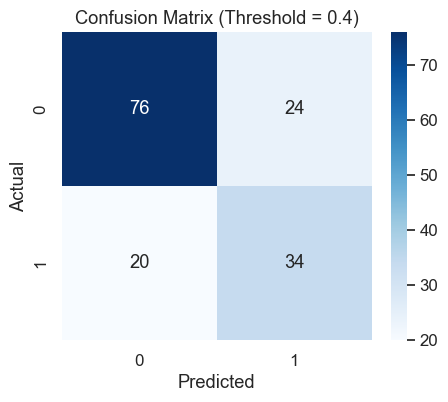

              precision    recall  f1-score   support

           0       0.79      0.76      0.78       100
           1       0.59      0.63      0.61        54

    accuracy                           0.71       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.72      0.71      0.72       154



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Threshold = 0.4)")
plt.show()

print(classification_report(y_test, y_pred))


In [12]:
import numpy as np
from sklearn.metrics import f1_score, recall_score

y_prob = best_model.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.2, 0.6, 0.05)

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    r = recall_score(y_test, y_pred_t)
    f = f1_score(y_test, y_pred_t)
    print(f"Threshold {t:.2f} | Recall: {r:.2f} | F1: {f:.2f}")


Threshold 0.20 | Recall: 0.89 | F1: 0.65
Threshold 0.25 | Recall: 0.87 | F1: 0.68
Threshold 0.30 | Recall: 0.80 | F1: 0.67
Threshold 0.35 | Recall: 0.70 | F1: 0.65
Threshold 0.40 | Recall: 0.63 | F1: 0.61
Threshold 0.45 | Recall: 0.56 | F1: 0.57
Threshold 0.50 | Recall: 0.48 | F1: 0.53
Threshold 0.55 | Recall: 0.46 | F1: 0.53


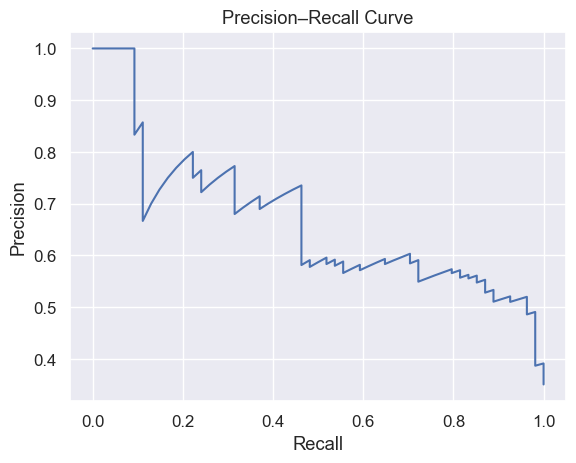

In [13]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()


In [14]:
full_pipeline.set_params(selector='passthrough')


,steps,"[('preprocessor', ...), ('selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('skew', ...), ('norm', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
